In [17]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Conectar con MLflow local
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

In [19]:
# Lista de experimentos que quieres comparar
experimentos = [
    "DQN_SpaceInvaders",
    "DQN_SpaceInvaders_Optuna",
    "A2C_SpaceInvaders",
    "A2C_SpaceInvaders_optuna",
    "PPO_SpaceInvaders"
]

# Obtener los runs de cada experimento
todos_los_runs = []

In [20]:
# Inspecciona un run cualquiera de uno de los experimentos
exp = client.get_experiment_by_name("DQN_SpaceInvaders")
runs = client.search_runs(exp.experiment_id)

# Muestra las métricas registradas en el primer run
runs[0].data.metrics

{'action_0_count': 908.0,
 'action_0_percentage': 0.03415845308855617,
 'action_1_count': 13502.0,
 'action_1_percentage': 0.5079377022044993,
 'action_2_count': 1285.0,
 'action_2_percentage': 0.048340982619817924,
 'action_3_count': 752.0,
 'action_3_percentage': 0.02828982017906854,
 'action_4_count': 3129.0,
 'action_4_percentage': 0.11771123316529983,
 'action_5_count': 7006.0,
 'action_5_percentage': 0.26356180874275825,
 'episode_length_mean': 265.99,
 'episode_length_std': 6.428499047211565,
 'episode_reward_max': 31.0,
 'episode_reward_mean': 8.12,
 'episode_reward_min': 0.0,
 'episode_reward_std': 6.428499047211565,
 'exploration_rate': 0.01,
 'loss_mean': 0.007111750543117523,
 'test_reward': 8.010000228881836,
 'test_reward_max': 17.0,
 'test_reward_min': 0.0,
 'test_reward_std': 5.518143177032471,
 'timesteps': 10000000.0,
 'training_updates': 2474999.0}

# Análisis del rendimiento en test (test_reward) y su consistencia

In [21]:
for nombre in experimentos:
    exp = client.get_experiment_by_name(nombre)
    if exp is not None:
        runs = client.search_runs(exp.experiment_id)
        for run in runs:
            valor = run.data.metrics.get(metric_name)
            if valor is not None:
                datos = {
                    "experiment": nombre,
                    "run_id": run.info.run_id,
                    metric_name: valor
                }
                todos_los_runs.append(datos)

df = pd.DataFrame(todos_los_runs)
df[metric_name] = df[metric_name].astype(float)
df.head()


,experiment,run_id,test_reward
0,DQN_SpaceInvaders,914f23523dcf4539966b840d8b4d6955,8.01
1,DQN_SpaceInvaders,74e3f6259b2b41919eb3f05a79c75b11,4.14
2,DQN_SpaceInvaders,e68170d3002f41529497b13366d51e06,5.62
3,DQN_SpaceInvaders,58963b0bf631429a95513259eb63338b,0.00
4,DQN_SpaceInvaders,6bcfe267164e42c2acdfc8a278b0b4c9,5.95


In [22]:
mejores_runs = []

for nombre in experimentos:
    exp = client.get_experiment_by_name(nombre)
    if exp is not None:
        runs = client.search_runs(exp.experiment_id)
        # Filtrar solo los que tienen test_reward
        runs_con_reward = [run for run in runs if "test_reward" in run.data.metrics]
        if not runs_con_reward:
            continue
        # Ordenar por test_reward descendente
        mejor_run = max(runs_con_reward, key=lambda r: r.data.metrics["test_reward"])
        mejores_runs.append({
            "experiment": nombre,
            "run_id": mejor_run.info.run_id,
            "test_reward": mejor_run.data.metrics["test_reward"]
        })

# DataFrame con los mejores runs
df_best = pd.DataFrame(mejores_runs)
df_best["test_reward"] = df_best["test_reward"].astype(float)
df_best


,experiment,run_id,test_reward
0,DQN_SpaceInvaders,d8e3ea56f6bc46f9aef82c2ea870db51,15.90
1,DQN_SpaceInvaders_Optuna,dd77d1d506064c8987b5070586b8803a,5.98
2,A2C_SpaceInvaders,f445012c13154edcbadfe3ed0f7187ef,31.51
3,A2C_SpaceInvaders_optuna,ab6e516b31474256a849882d8c73cd64,17.26
4,PPO_SpaceInvaders,95c2decd982545278b2929f016ad6d44,52.82


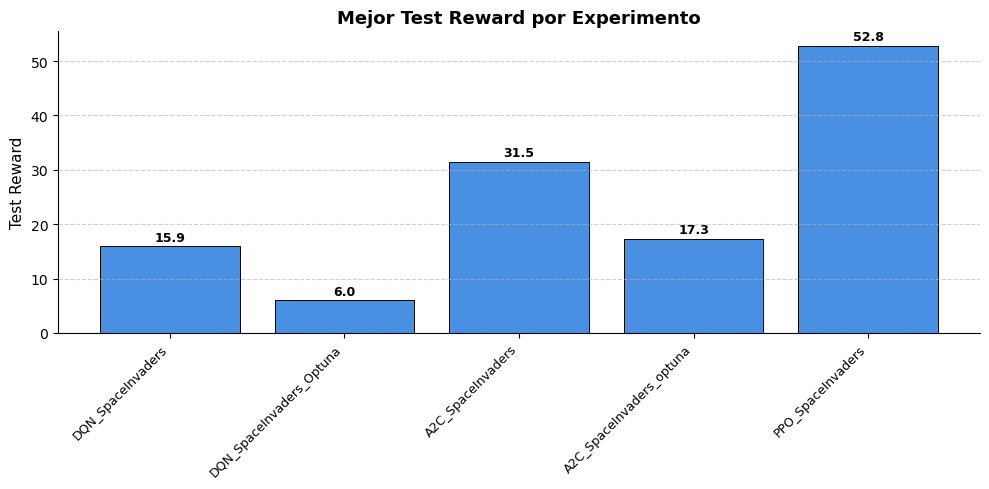

In [23]:
plt.figure(figsize=(10, 5))
bars = plt.bar(df_best["experiment"], df_best["test_reward"], color="#4A90E2", edgecolor="black", linewidth=0.7)

# Agregar etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylabel("Test Reward", fontsize=11)
plt.title("Mejor Test Reward por Experimento", fontsize=13, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Opcional: quitar bordes superiores y derechos para estilo más limpio
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


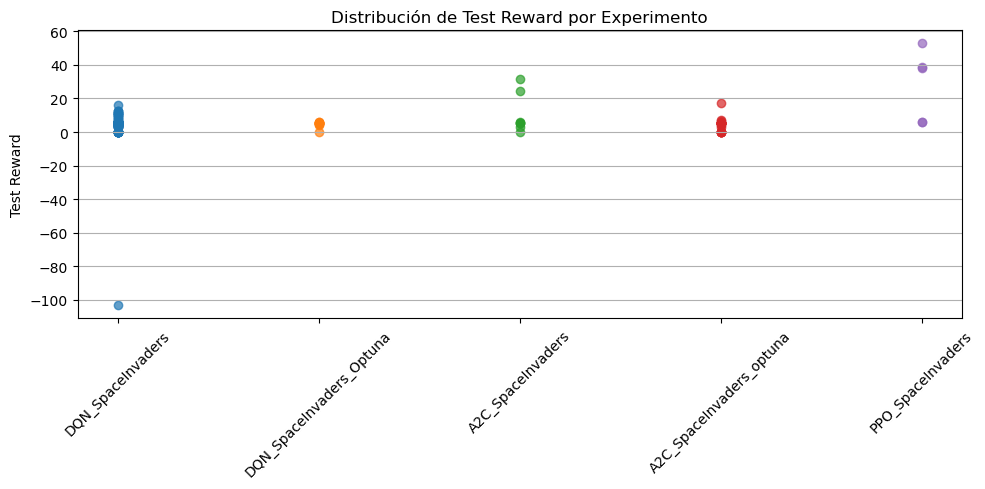

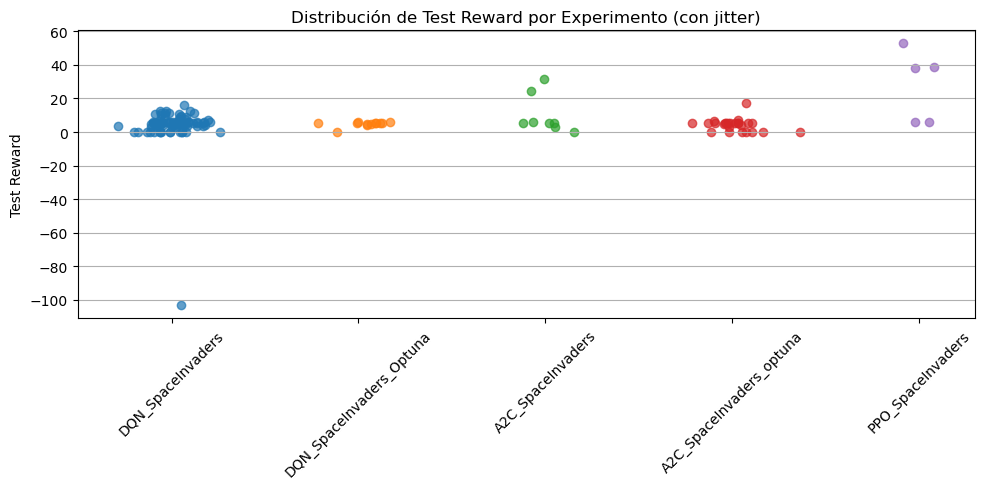

In [24]:
plt.figure(figsize=(10, 5))
for nombre in df["experiment"].unique():
    sub_df = df[df["experiment"] == nombre]
    plt.scatter([nombre]*len(sub_df), sub_df["test_reward"], alpha=0.7, label=nombre)

plt.title("Distribución de Test Reward por Experimento")
plt.ylabel("Test Reward")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

import numpy as np

plt.figure(figsize=(10, 5))
for i, nombre in enumerate(df["experiment"].unique()):
    sub_df = df[df["experiment"] == nombre]
    jitter_x = np.random.normal(loc=i, scale=0.1, size=len(sub_df))  # jitter horizontal
    plt.scatter(jitter_x, sub_df["test_reward"], alpha=0.7, label=nombre)

plt.title("Distribución de Test Reward por Experimento (con jitter)")
plt.ylabel("Test Reward")
plt.xticks(ticks=range(len(df["experiment"].unique())), labels=df["experiment"].unique(), rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Basándonos en el test_reward máximo por experimento, el algoritmo PPO logró el mejor rendimiento absoluto (52.8), seguido por A2C (31.5) y QRDQN (26.5). Por el contrario, DQN con Optuna obtuvo el peor resultado (6.0).

Pero más importante que el valor máximo, al observar la distribución completa de test_reward por experimento, podemos sacar conclusiones más robustas sobre consistencia y estabilidad:

1. PPO_SpaceInvaders
* Alto rendimiento en múltiples ejecuciones.
* Pocos valores bajos → muy consistente.
* El mejor balance entre rendimiento y robustez.

2. A2C_SpaceInvaders
* Distribución más amplia: algunos runs muy buenos, otros modestos.
* Buen resultado medio, pero menos consistente que PPO.

3. A2C_SpaceInvaders_Optuna
* Distribución estrecha con valores bajos-medios.
* Mejor estabilidad que su versión sin Optuna, pero sin grandes mejoras de rendimiento.

4. DQN_SpaceInvaders y DQN_SpaceInvaders_Optuna
* Valores concentrados en la parte baja.
* Un outlier extremo a -100 en DQN indica gran inestabilidad.
* En general, rendimiento pobre y poco fiable, incluso con Optuna.

# Análisis del aprendizaje durante entrenamiento

In [26]:
# Agrupar por experimento y calcular medias y desviaciones estándar
stats = df_train.groupby("experiment").agg({
    "episode_reward_mean": ["mean", "std"],
    "episode_reward_std": ["mean", "std"],
    "loss_mean": ["mean", "std"],
    "timesteps": ["mean"],
    "training_updates": ["mean"]
}).round(2)

# Aplanar el MultiIndex de columnas
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats.reset_index(inplace=True)
stats

,experiment,episode_reward_mean_mean,episode_reward_mean_std,episode_reward_std_mean,episode_reward_std_std,loss_mean_mean,loss_mean_std,timesteps_mean,training_updates_mean
0,A2C_SpaceInvaders,10.38,12.76,10.28,15.22,NaN,NaN,4769255.38,74530.17
1,A2C_SpaceInvaders_optuna,4.16,1.65,2.96,1.65,NaN,NaN,4825925.93,30161.04
2,DQN_SpaceInvaders,1.84,58.91,17.04,26.98,0.04,0.05,1532455.45,323000.06
3,DQN_SpaceInvaders_Optuna,5.29,0.66,3.52,0.53,0.03,0.03,750000.00,184999.00
4,PPO_SpaceInvaders,22.43,20.08,20.00,18.07,0.08,0.06,6610000.00,47066.40


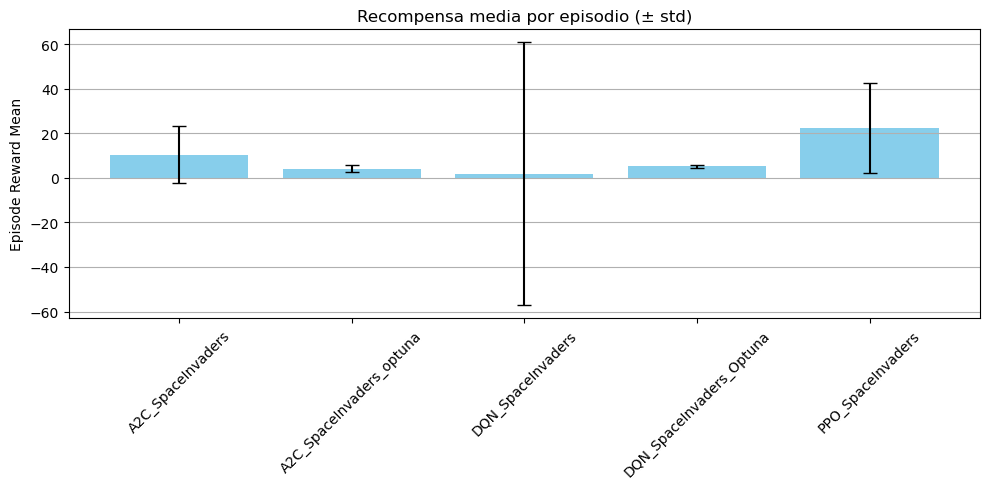

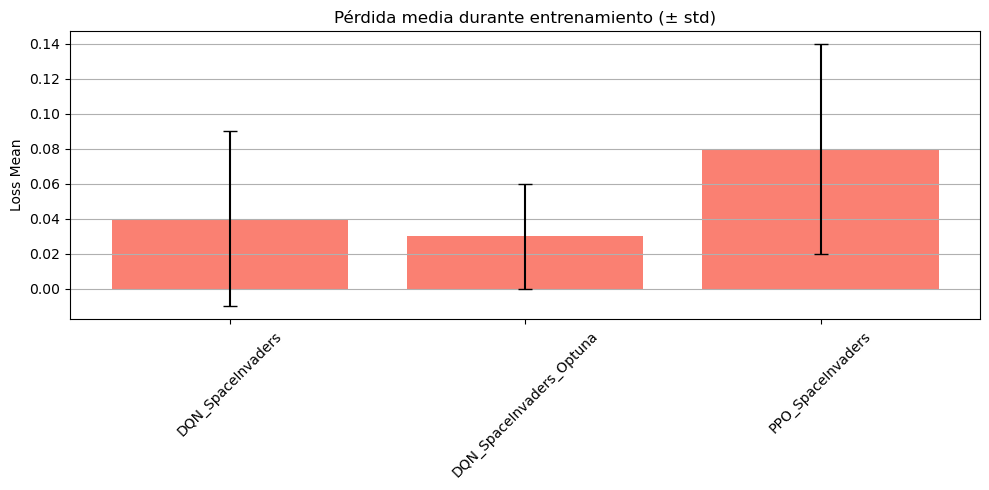

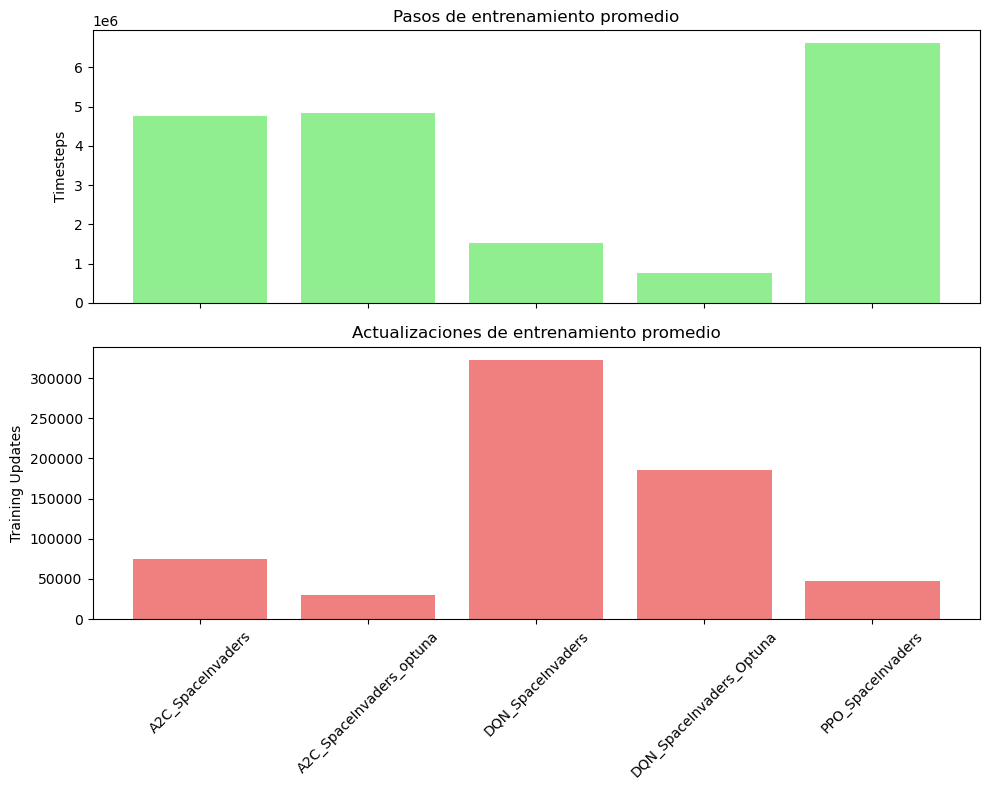

In [29]:


# --- GRÁFICA 1: Recompensa media por episodio (± std) ---
plt.figure(figsize=(10, 5))
plt.bar(stats["experiment"], stats["episode_reward_mean_mean"], 
        yerr=stats["episode_reward_mean_std"], capsize=5, color='skyblue')
plt.ylabel("Episode Reward Mean")
plt.title("Recompensa media por episodio (± std)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- GRÁFICA 2: Pérdida media durante entrenamiento ---
df_loss = stats.dropna(subset=["loss_mean_mean"])

plt.figure(figsize=(10, 5))
plt.bar(df_loss["experiment"], df_loss["loss_mean_mean"], 
        yerr=df_loss["loss_mean_std"], capsize=5, color='salmon')
plt.ylabel("Loss Mean")
plt.title("Pérdida media durante entrenamiento (± std)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- GRÁFICA 3: Esfuerzo computacional ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].bar(stats["experiment"], stats["timesteps_mean"], color='lightgreen')
axs[0].set_ylabel("Timesteps")
axs[0].set_title("Pasos de entrenamiento promedio")

axs[1].bar(stats["experiment"], stats["training_updates_mean"], color='lightcoral')
axs[1].set_ylabel("Training Updates")
axs[1].set_title("Actualizaciones de entrenamiento promedio")

plt.xticks(ticks=range(len(stats["experiment"])), labels=stats["experiment"], rotation=45)
plt.tight_layout()
plt.show()


1. Recompensa media por episodio
* PPO destaca con la recompensa más alta y amplia variación → potente pero inconsistente.
* DQN tiene una varianza extrema (algunos runs malísimos) → muy inestable.
* A2C y A2C_Optuna muestran consistencia moderada, especialmente la versión con Optuna.

Conclusión: PPO es el mejor en reward, pero A2C_Optuna es más estable.

2. Pérdida media (loss_mean)
* PPO tiene la mayor pérdida media (esperable por su mayor complejidad).
* DQN y Optuna-DQN tienen pérdidas moderadas.
* Faltan datos de A2C (quizás no se registró), pero el resto permite ver convergencia relativa.

Conclusión: la pérdida no se correlaciona directamente con reward, pero indica inestabilidad.

3. Timesteps (pasos de entrenamiento)
* PPO y A2C usan más pasos → aprendizaje largo.
* DQN usa menos pasos, pero los resultados de rendimiento son muy bajos

4. Training updates
* DQN hace muchísimas actualizaciones, lo que muestra ineficiencia computacional.
* PPO logra más con menos updates → más eficiente.

Conclusión: DQN desperdicia recursos, PPO es más productivo por update.



# Conclusiones

PPO es el algoritmo más recomendable, por su alto rendimiento medio, buen uso de recursos y capacidad de generalización, a pesar de su variabilidad.
A2C (sin Optuna) es una buena segunda opción si se prioriza estabilidad, y A2C_Optuna si el objetivo es mantener el comportamiento constante con bajo coste.
Se desaconseja el uso de DQN en este entorno sin cambios sustanciales en diseño o configuración.